# Differentially Private Provenance Graphs

## Run Algorithm

In [97]:
import pickle
from pathlib import Path
import argparse
import yaml
import pandas as pd
import evaluate


graph_name = 'nd-352579631-processletevent'

epsilon_values = [0.001, 0.01, 0.1, 0.5, 1.0, 2, 5, 10]
alpha_values = [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 3]
if True:
    results = evaluate.main(
        input_directory = '../data/input',
        output_directory = '../data/output',
        graph_name = graph_name,
        epsilon_1_values = epsilon_values,
        epsilon_2_values = [1.0],
        alpha_values = alpha_values,
        num_samples = 50,
        parallel = True
    )
    with open(f'../data/output/{graph_name}/results.p', mode='wb') as file:
        pickle.dump(results, file)

(10.0,1.0,3.0): 100%|██████████| 50/50 [01:20<00:00,  1.60s/it]


In [98]:
with open(f'../data/output/{graph_name}/results.p', mode='rb') as f:
    results = pickle.load(f)

## Create Graphs

In [99]:
import pandas as pd

df: pd.DataFrame = results.copy(deep=True)
df

,epsilon_1,epsilon_2,alpha,sizes of subtree pruned avg,sizes of subtree pruned stdev,sizes of subtree pruned min,sizes of subtree pruned max,#pruned at depth=0,#pruned at depth=1,#pruned at depth=2,...,#edges kept avg,#edges kept stdev,#edges kept min,#edges kept max,#disconnected nodes avg,#disconnected nodes stdev,#disconnected nodes min,#disconnected nodes max,#pruned at depth=12,#pruned at depth=13
0,0.001,1.0,0.001,9.692214,80.164313,1,979,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,"{'[FILE]-Access_File-[PROCESS_LET]': 2938, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 2308, '[F...",...,351.02,287.641895,0,977,1108.96,222.191625,683,1393,NaN,NaN
1,0.001,1.0,0.01,9.811771,79.923197,1,979,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,"{'[FILE]-Access_File-[PROCESS_LET]': 3203, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 2417, '[F...",...,385.78,275.979223,0,926,1084.14,204.857122,661,1393,NaN,NaN
2,0.001,1.0,0.1,6.28584,58.87035,1,948,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,"{'[FILE]-Access_File-[PROCESS_LET]': 2491, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 4006, '[F...",...,534.76,246.231238,220,1058,943.68,175.346678,598,1203,NaN,NaN
3,0.001,1.0,0.25,5.489276,55.210949,1,948,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,{'[PROCESS_LET]-End_Processlet-[PROCESS_LET]':...,...,659.38,233.218772,381,1087,837.98,163.050236,570,1048,NaN,NaN
4,0.001,1.0,0.5,5.478386,56.63593,1,948,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,"{'[FILE]-Access_File-[PROCESS_LET]': 3151, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 5299, '[F...",...,800.48,250.505588,524,1226,732.54,173.573179,454,936,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,10.0,1.0,0.25,1.205458,1.594024,1,50,NaN,"{'[FILE]-Access_File-[PROCESS_LET]': 3785, '[P...","{'[PROCESS_LET]-Access_File-[FILE]': 6459, '[F...",...,1216.84,32.112527,1143,1292,516.3,26.0747,458,569,NaN,NaN
60,10.0,1.0,0.5,1.09922,0.826499,1,22,NaN,"{'[FILE]-Access_File-[PROCESS_LET]': 791, '[PR...","{'[PROCESS_LET]-Access_File-[FILE]': 4449, '[F...",...,1466.06,17.81057,1425,1501,359.54,14.497186,327,398,NaN,NaN
61,10.0,1.0,1.0,1.01376,0.151895,1,4,NaN,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,{'[PROCESS_LET]-End_Processlet-[PROCESS_LET]':...,...,1663.28,12.285015,1639,1690,203.3,12.017071,180,233,NaN,NaN
62,10.0,1.0,2.0,1.0,0.0,1,1,NaN,{'[PROCESS_LET]-Start_Processlet-[PROCESS_LET]...,{'[PROCESS_LET]-Transfer_IP_Data-[IP_CHANNEL]'...,...,1891.96,3.065681,1886,1897,13.46,3.054243,8,21,NaN,NaN


In [100]:
df['avg %edges kept'] = df['#edges kept avg']/df['original #edges']

KeyError: 'original #edges'

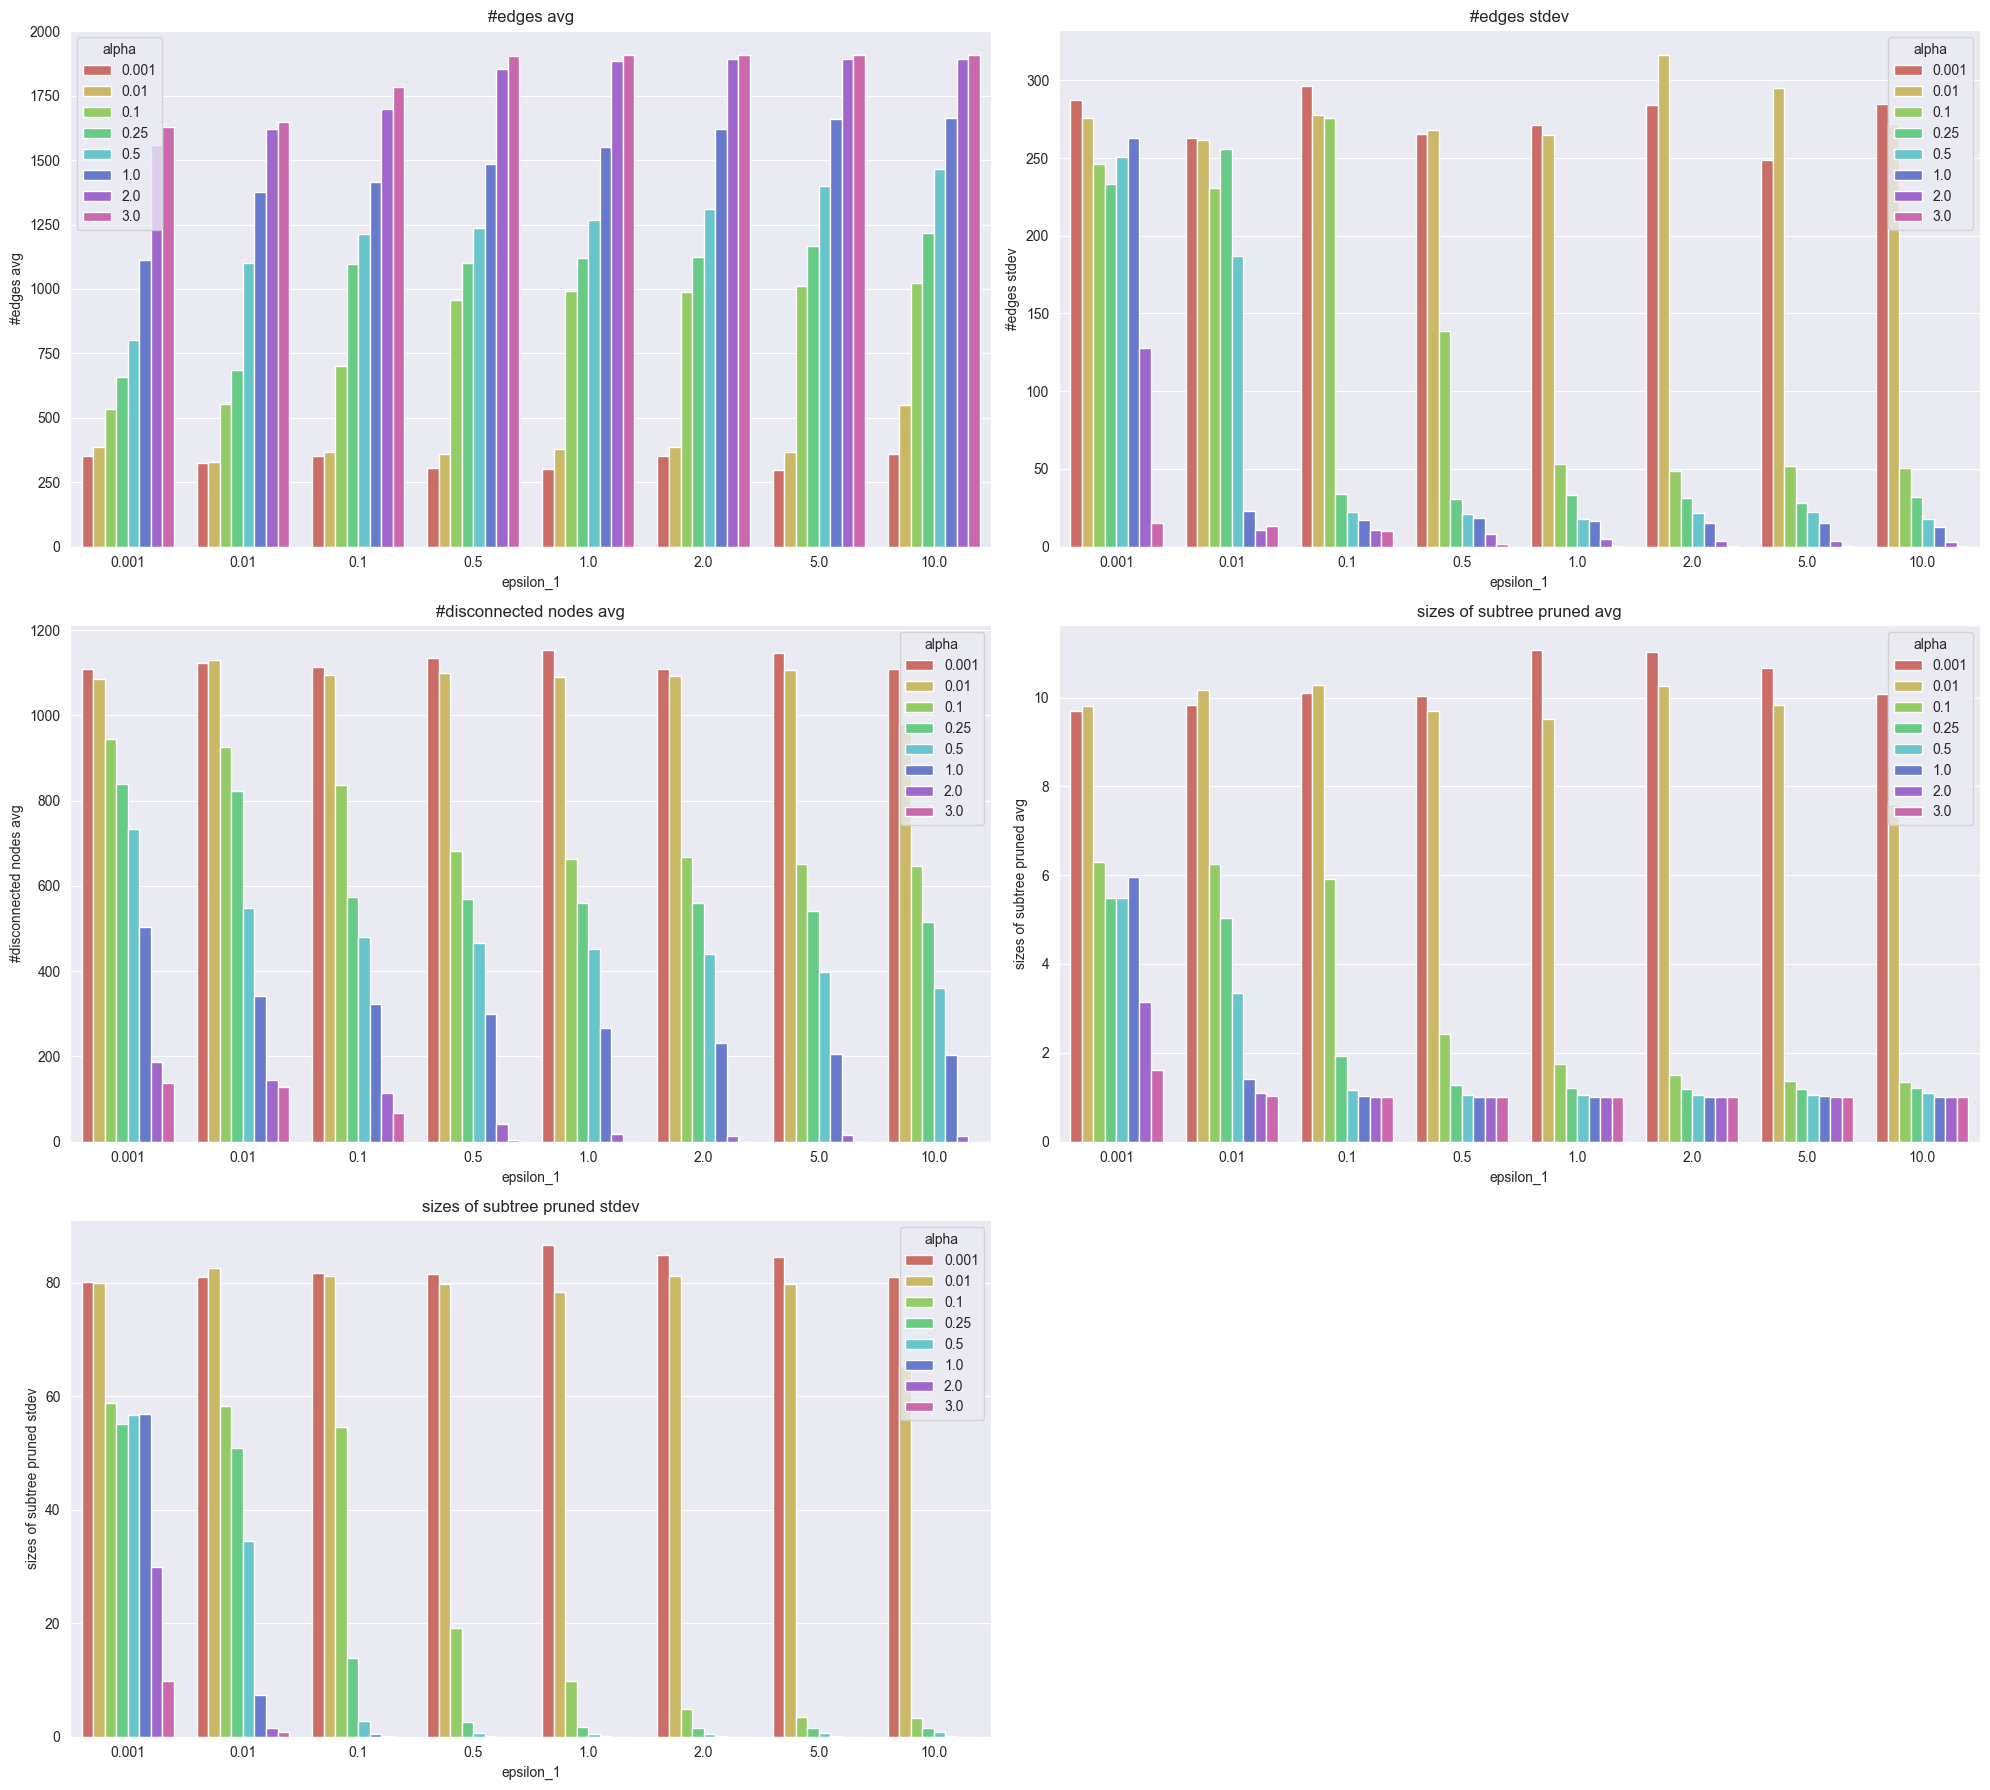

In [102]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
# TODO: convert back to plotly
stats = ['#edges avg', '#edges stdev', '#disconnected nodes avg', #'avg %edges kept',
         'sizes of subtree pruned avg', 'sizes of subtree pruned stdev']
cols = 2
rows = math.ceil(len(stats) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 6))
axes = axes.flatten()
def create_figure(x_column: str, y_column: str, ax: plt.Axes):
    palette = sns.color_palette('hls', len(df['alpha'].unique()))
    sns.barplot(data=df,
                x=x_column,
                y=y_column,
                ax=ax,
                hue='alpha',
                palette=palette)
    ax.set_title(y_column)

for i, stat in enumerate(stats):
    create_figure('epsilon_1', stat, axes[i])
for j in range(i + 1, rows * cols):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

## Average number of nodes pruned by depth

In [ ]:
from collections import Counter
import plotly.express as px
from algorithm import PRUNED_AT_DEPTH

id_vars = ['epsilon_1', 'alpha']
depth_df = df.loc[:,id_vars]
depth_values = []
def sum_counter(counter: Counter):
    if not isinstance(counter, Counter):
        return 0
    return sum(counter.values())
for column in df.columns:
    if column.startswith(PRUNED_AT_DEPTH):
        depth = column[len(PRUNED_AT_DEPTH)+1:]
        depth_values.append(depth)
        depth_df[depth] = df[column].apply(sum_counter)
        
        
id_vars = ['epsilon_1', 'alpha']
depth_df = depth_df.melt(id_vars=id_vars,
              value_vars=depth_values,
              var_name='depth',
              value_name='#pruned').sort_values(id_vars)

In [ ]:
import numpy as np
depth_df['depth'] = depth_df['depth'].astype(int)
depth_df['alpha'] = depth_df['alpha'].astype(str)
depth_df['%pruned'] = depth_df.groupby(['epsilon_1', 'alpha'])['#pruned'].transform(lambda x: x / x.sum())
depth_df['%pruned'] = depth_df['%pruned'].apply(lambda p: np.round(p, 3))
fig = px.bar(
    depth_df,
    x='alpha', y='%pruned',
    facet_col='epsilon_1',
    color='depth',
    text='%pruned',
    text_auto=True,
    labels={'epsilon_1': 'epsilon'}
)
fig.update_layout(
    coloraxis_colorbar={
        'tickvals': depth_values,
        'ticktext': depth_values
    }
)
fig.show()

In [ ]:
fig.write_image('pruning_by_depth.pdf')